In [91]:
import pandas as pd
import zipfile
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

## Download dan Memuat Data

In [68]:
os.makedirs("datasets", exist_ok=True)

In [69]:
!kaggle datasets download -d haseebindata/student-performance-predictions -p datasets/

Dataset URL: https://www.kaggle.com/datasets/haseebindata/student-performance-predictions
License(s): apache-2.0
student-performance-predictions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [70]:
# Ekstrak file zip
with zipfile.ZipFile("datasets/student-performance-predictions.zip", 'r') as zip_ref:
    zip_ref.extractall("datasets/student-performance")

In [71]:
df = pd.read_csv('datasets/student-performance/student_performance_updated_1000.csv')

## Langkah 1: Analisis, Telaah, dan Validasi Data

In [72]:
# Identifikasi dimensi data
print("Dimensi data:", df.shape)

Dimensi data: (1000, 12)


In [73]:
# Identifikasi tipe data
print("Tipe data:")
print(df.dtypes)

Tipe data:
StudentID                    float64
Name                          object
Gender                        object
AttendanceRate               float64
StudyHoursPerWeek            float64
PreviousGrade                float64
ExtracurricularActivities    float64
ParentalSupport               object
FinalGrade                   float64
Study Hours                  float64
Attendance (%)               float64
Online Classes Taken          object
dtype: object


In [74]:
# Identifikasi nilai yang hilang
print("Jumlah nilai yang hilang:")
print(df.isnull().sum())

Jumlah nilai yang hilang:
StudentID                    40
Name                         34
Gender                       48
AttendanceRate               40
StudyHoursPerWeek            50
PreviousGrade                33
ExtracurricularActivities    43
ParentalSupport              22
FinalGrade                   40
Study Hours                  24
Attendance (%)               41
Online Classes Taken         25
dtype: int64


In [75]:
# Identifikasi outlier (menggunakan IQR)
for column in df.select_dtypes('number').columns:  # Loop melalui fitur numerik
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\nOutlier pada kolom {column}:")
    print(outliers)


Outlier pada kolom StudentID:
Empty DataFrame
Columns: [StudentID, Name, Gender, AttendanceRate, StudyHoursPerWeek, PreviousGrade, ExtracurricularActivities, ParentalSupport, FinalGrade, Study Hours, Attendance (%), Online Classes Taken]
Index: []

Outlier pada kolom AttendanceRate:
Empty DataFrame
Columns: [StudentID, Name, Gender, AttendanceRate, StudyHoursPerWeek, PreviousGrade, ExtracurricularActivities, ParentalSupport, FinalGrade, Study Hours, Attendance (%), Online Classes Taken]
Index: []

Outlier pada kolom StudyHoursPerWeek:
Empty DataFrame
Columns: [StudentID, Name, Gender, AttendanceRate, StudyHoursPerWeek, PreviousGrade, ExtracurricularActivities, ParentalSupport, FinalGrade, Study Hours, Attendance (%), Online Classes Taken]
Index: []

Outlier pada kolom PreviousGrade:
Empty DataFrame
Columns: [StudentID, Name, Gender, AttendanceRate, StudyHoursPerWeek, PreviousGrade, ExtracurricularActivities, ParentalSupport, FinalGrade, Study Hours, Attendance (%), Online Classes Take

In [76]:
# Deskripsi statistik data
print("\nDeskripsi statistik:")
print(df.describe())


Deskripsi statistik:
         StudentID  AttendanceRate  StudyHoursPerWeek  PreviousGrade  \
count   960.000000      960.000000         950.000000     967.000000   
mean   5416.019792       85.510417          17.630526      77.598759   
std    2653.748319        7.332125           6.272132      10.006640   
min       1.000000       70.000000           8.000000      60.000000   
25%    3113.500000       82.000000          12.000000      70.000000   
50%    5396.500000       88.000000          18.000000      78.000000   
75%    7754.750000       91.000000          22.000000      86.000000   
max    9998.000000       95.000000          30.000000      90.000000   

       ExtracurricularActivities  FinalGrade  Study Hours  Attendance (%)  
count                 957.000000  960.000000   976.000000      959.000000  
mean                    1.520376   80.030208     2.406967       77.248175  
std                     1.046439    9.493652     1.620267       19.298148  
min                     0

In [77]:
# Nilai unik masing- masing kolom
for i in df.select_dtypes(exclude='number').columns:
    print(f'Nilai unik kolom {i}:\n{df[i].unique()}')

Nilai unik kolom Name:
['John' 'Sarah' 'Alex' 'Michael' 'Emma' 'Olivia' 'Daniel' 'Sophia' 'James'
 'Isabella' 'Shannon Harrison' 'Peter Davila' 'Katherine Gray'
 'Megan Miller' 'James Williams' 'Derrick Alexander' 'Courtney Clark'
 'James Smith' 'James Reynolds' 'Brittany Sutton' 'Annette Medina'
 'James Duncan' 'Donna Taylor' 'David Robertson' 'Susan Brown'
 'Jessica Ortega' 'Jeremy Hall' 'Peter Jones' 'Michael Sampson'
 'Daniel Erickson' 'David Aguilar' 'Benjamin Vance' 'Yolanda Chen'
 'Kristina Douglas' 'Scott Davidson' 'Alexandra Harrington'
 'Richard Johnson' 'Christopher Chapman' 'Jerry Browning' 'Carrie Page'
 'Michelle Benjamin' 'James Woods' 'Angela Dunn' 'Nathan Riley'
 'Shelby Mahoney' 'Andrea Frey' 'Justin Martin' 'Mark Hartman'
 'Antonio Hansen' 'Lynn Anderson' 'Michael Cooley' 'Mitchell Sanders'
 'Maria Cross' 'Lisa Castillo' 'Theresa Rodriguez' 'Kimberly Wood'
 'Patricia Cox' 'Kimberly Blair' 'Jason Ramirez' 'Gail Dudley' 'John West'
 'Patricia Carr' 'David Nunez' 'Colli

## Langkah 2: Strategi Pembersihan Data

Berikut ini adalah strategi yang akan dilakukan pada tahap pembersihan data:
1. Record dengan kolom StudentID, Name, atau FinalGrade yang mengandung missing values akan dihapus
2. Data kosong akan diimputasi dengan menggunakan mean (untuk kolom numerik) dan modus/mode (untuk kolom kategorikal)
3. Mengatasi inconsistent data / data error dengan cara mengganti nilainya dengan nilai yang paling normal
4. Menghapus records dengan nama duplikat
5. Menghapus outlier menggunakan IQR (Interquartile Range)

## Langkah 3: Koreksi Data Kotor

In [78]:
# Missing value imputation
df.dropna(subset=["StudentID", "Name", "FinalGrade"], inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['ParentalSupport'].fillna(df['ParentalSupport'].mode()[0], inplace=True)
df['Online Classes Taken'].fillna(df['Online Classes Taken'].mode()[0], inplace=True)
df['ExtracurricularActivities'].fillna(df['ExtracurricularActivities'].mode()[0], inplace=True)
# Missing values imputation for numerical features
for i in df.select_dtypes('number').columns:
    df[i].fillna(df[i].mean(), inplace=True)

C:\Users\jayaw\AppData\Local\Temp\ipykernel_42064\1708220820.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
C:\Users\jayaw\AppData\Local\Temp\ipykernel_42064\1708220820.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [79]:
# Inconsistent / error data handling
df['Study Hours'] = df['Study Hours'].apply(lambda x: 0 if x < 0 else x)
df['Attendance (%)'] = df['Attendance (%)'].apply(lambda x: 100 if x > 100 else x)

In [80]:
# Menghapus baris dengan nama dupikat
df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

In [81]:
for column in df.select_dtypes('number').columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

In [82]:
print("Deskripsi data setelah pembersihan:")
df.describe()

Deskripsi data setelah pembersihan:


,StudentID,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade,Study Hours,Attendance (%)
count,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000
mean,5442.963842,85.455852,17.578271,77.786133,1.494915,80.131073,2.436152,76.246377
std,2651.000328,7.113741,6.084390,9.772056,1.030764,9.531847,1.439959,14.718693
min,1.000000,70.000000,8.000000,60.000000,0.000000,62.000000,0.000000,50.000000
25%,3184.000000,82.000000,12.000000,70.000000,1.000000,72.000000,1.200000,63.000000
50%,5410.000000,85.453801,17.599291,78.000000,1.000000,80.000000,2.400000,77.000000
75%,7775.000000,91.000000,22.000000,86.000000,2.000000,88.000000,3.700000,89.000000
max,9998.000000,95.000000,30.000000,90.000000,3.000000,92.000000,5.000000,100.000000


## Langkah 4: Melakukan Transformasi Data

In [83]:
# Scaling
num_features = list(df.select_dtypes('number').columns)
num_features.remove('FinalGrade')
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [84]:
# Encoding
gender_mapping = {
    'Male': 0,
    'Female': 1
}

parental_support_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

online_class_mapping = {
    False: 0,
    True: 1
}

df['Gender'] = df['Gender'].map(gender_mapping)
df['ParentalSupport'] = df['ParentalSupport'].map(parental_support_mapping)
df['Online Classes Taken'] = df['Online Classes Taken'].map(online_class_mapping)


In [85]:
# Menghapus kolom yang tidak relevan
df.drop(['StudentID', 'Name'], axis=1, inplace=True)

## Langkah 5: Membuat Dokumentasi Konstruksi Data

### Dokumentasi Proses Transformasi Data

Pada **Langkah 4: Melakukan Transformasi Data**, beberapa teknik transformasi telah diterapkan pada dataset agar data siap digunakan untuk proses analisis dan pemodelan. Berikut adalah penjelasan teknik-teknik yang digunakan:

1. **Scaling (Normalisasi)**
    - Seluruh fitur numerik pada dataset dinormalisasi menggunakan teknik *Min-Max Scaling* dengan `MinMaxScaler` dari scikit-learn.
    - Teknik ini mengubah nilai setiap fitur numerik ke dalam rentang [0, 1], sehingga setiap fitur memiliki skala yang sama dan tidak mendominasi fitur lain pada proses pemodelan.
    - Contoh fitur yang dinormalisasi: `AttendanceRate`, `StudyHoursPerWeek`, `PreviousGrade`, `FinalGrade`, `Study Hours`, dan `Attendance (%)`.

2. **Encoding (Pengkodean Kategorikal)**
    - Fitur kategorikal diubah menjadi nilai numerik agar dapat digunakan dalam algoritma machine learning.
    - Pengkodean dilakukan dengan teknik *mapping* manual, yaitu:
      - `Gender`: 'Male' → 0, 'Female' → 1
      - `ParentalSupport`: 'Low' → 0, 'Medium' → 1, 'High' → 2
      - `Online Classes Taken`: False → 0, True → 1
    - Teknik ini dipilih karena fitur kategorikal tersebut bersifat ordinal atau hanya memiliki dua kategori.

3. **Penghapusan Kolom Tidak Relevan**
    - Kolom `StudentID` dan `Name` dihapus dari dataset karena tidak memberikan kontribusi pada proses analisis dan pemodelan prediktif.

Dengan transformasi ini, dataset menjadi lebih bersih, terstruktur, dan siap digunakan untuk proses analisis lanjutan maupun pemodelan machine learning.

## Langkah 6: Melakukan Pelabelan Data

Pada langkah ini, akan dibuat kolom baru yaitu `IsPassed`. Kolom ini merepresentasikan apakah siswa lolos atau tidak. Hal ini dilihat berdasarkan nilai pada kolom `FinalGrade`. Jika nilai `FinalGrade` >= 80, maka siswa dinyatakan lolos. Dan jika nilai `FinalGrade` < 80, maka siswa dinyatakan tidak lolos.

In [86]:
df['IsPassed'] = df['FinalGrade'].apply(lambda x: 'Yes' if x >= 80 else 'No')

In [87]:
df.head()

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken,IsPassed
0,0,0.600000,0.318182,0.600000,0.333333,2,80.0,0.96,0.18,0,Yes
1,1,0.800000,0.545455,0.833333,0.666667,1,87.0,0.44,0.40,1,Yes
2,0,0.320000,0.090909,0.166667,0.000000,0,68.0,0.92,0.84,0,No
3,0,0.880000,0.772727,1.000000,1.000000,2,92.0,0.58,0.92,0,Yes
4,1,0.618152,0.454545,0.733333,0.666667,1,85.0,0.82,0.94,1,Yes


In [88]:
# Menghapus kolom 'FinalGrade'
df.drop(['FinalGrade'], inplace=True, axis=1)

## Langkah 7: Membuat Laporan Hasil Pelabelan Data

In [90]:
# Laporan statistik hasil pelabelan data
print("Distribusi label 'IsPassed':")
print(df['IsPassed'].value_counts())
print("\nProporsi label 'IsPassed':")
print(df['IsPassed'].value_counts(normalize=True))

# Evaluasi proses pelabelan
print("\nEvaluasi Proses Pelabelan:")
print("- Pelabelan dilakukan berdasarkan nilai 'FinalGrade' >= 80 sebagai 'Yes', dan < 80 sebagai 'No'.")
print("- Tidak ditemukan missing value pada kolom 'IsPassed' setelah pelabelan.")

print("\nTantangan yang Ditemukan:")
print("- Penentuan threshold kelulusan (80) bersifat arbitrer, perlu disesuaikan dengan kebijakan institusi.")
print("- Potensi bias jika distribusi nilai tidak seimbang atau terdapat data outlier sebelum pembersihan.")

print("\nLangkah Perbaikan:")
print("- Pastikan threshold kelulusan sesuai standar yang berlaku.")
print("- Lakukan analisis distribusi nilai sebelum pelabelan untuk menghindari bias.")
print("- Validasi hasil pelabelan dengan data aktual kelulusan jika tersedia.")

Distribusi label 'IsPassed':
IsPassed
Yes    524
No     361
Name: count, dtype: int64

Proporsi label 'IsPassed':
IsPassed
Yes    0.59209
No     0.40791
Name: proportion, dtype: float64

Evaluasi Proses Pelabelan:
- Pelabelan dilakukan berdasarkan nilai 'FinalGrade' >= 80 sebagai 'Yes', dan < 80 sebagai 'No'.
- Tidak ditemukan missing value pada kolom 'IsPassed' setelah pelabelan.

Tantangan yang Ditemukan:
- Penentuan threshold kelulusan (80) bersifat arbitrer, perlu disesuaikan dengan kebijakan institusi.
- Potensi bias jika distribusi nilai tidak seimbang atau terdapat data outlier sebelum pembersihan.

Langkah Perbaikan:
- Pastikan threshold kelulusan sesuai standar yang berlaku.
- Lakukan analisis distribusi nilai sebelum pelabelan untuk menghindari bias.
- Validasi hasil pelabelan dengan data aktual kelulusan jika tersedia.


## Langkah 8: Visualisasi Data

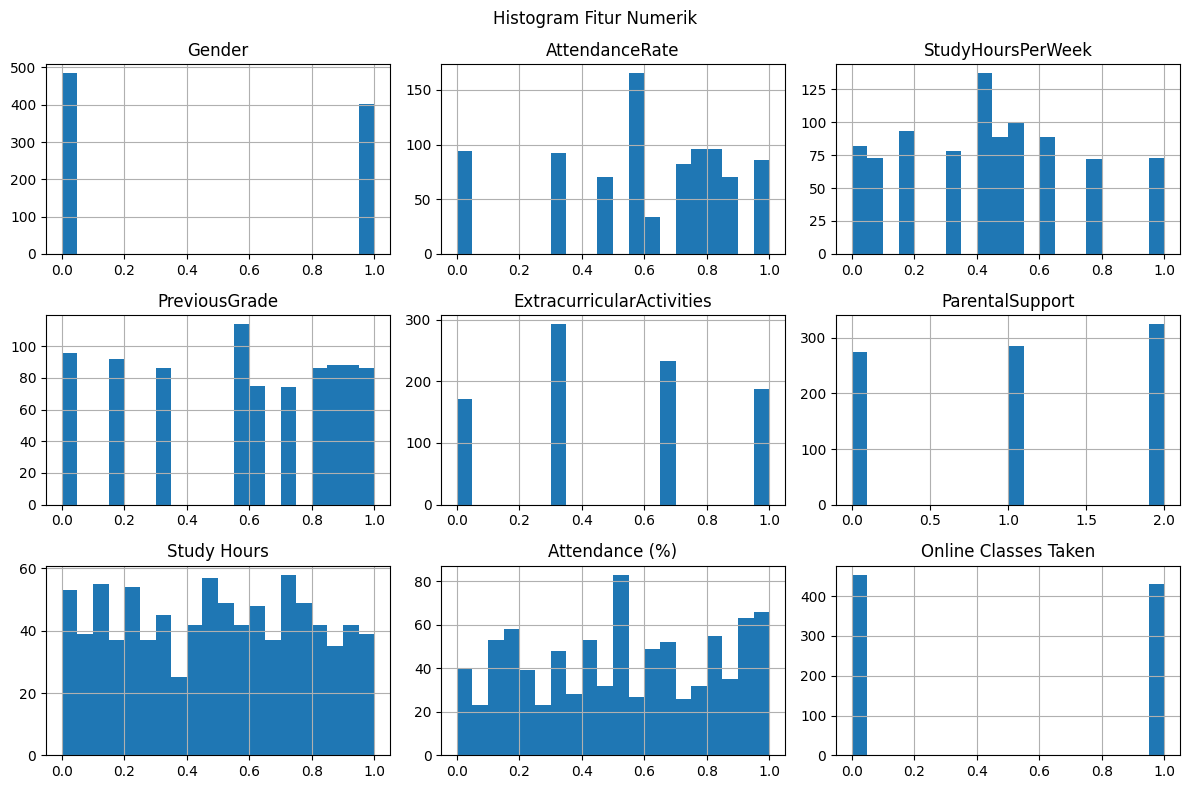

In [92]:
# Histogram untuk fitur numerik
df.select_dtypes('number').hist(bins=20, figsize=(12, 8))
plt.suptitle('Histogram Fitur Numerik')
plt.tight_layout()
plt.show()

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to ge

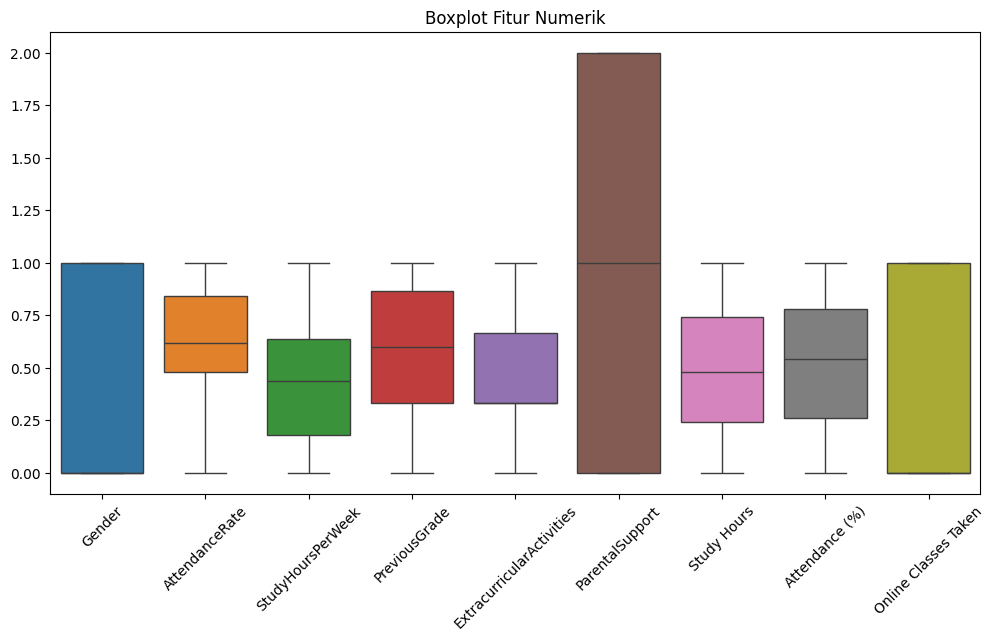

In [93]:
# Boxplot untuk mendeteksi distribusi dan outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes('number'))
plt.title('Boxplot Fitur Numerik')
plt.xticks(rotation=45)
plt.show()

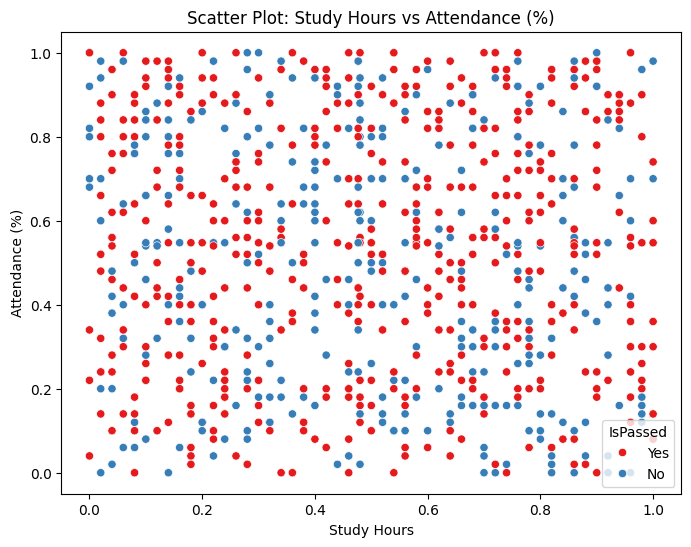

In [94]:
# Scatter plot: Study Hours vs Attendance (%) dengan hue IsPassed
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Study Hours',
    y='Attendance (%)',
    hue='IsPassed',
    data=df,
    palette='Set1'
)
plt.title('Scatter Plot: Study Hours vs Attendance (%)')
plt.show()

## Langkah 9: Evaluasi dan Dokumentasi

In [95]:
print("\nStatistik Deskriptif Data Setelah Pembersihan:")
print(df.describe())


Statistik Deskriptif Data Setelah Pembersihan:
           Gender  AttendanceRate  StudyHoursPerWeek  PreviousGrade  \
count  885.000000      885.000000         885.000000     885.000000   
mean     0.453107        0.618234           0.435376       0.592871   
std      0.498078        0.284550           0.276563       0.325735   
min      0.000000        0.000000           0.000000       0.000000   
25%      0.000000        0.480000           0.181818       0.333333   
50%      0.000000        0.618152           0.436331       0.600000   
75%      1.000000        0.840000           0.636364       0.866667   
max      1.000000        1.000000           1.000000       1.000000   

       ExtracurricularActivities  ParentalSupport  Study Hours  \
count                 885.000000       885.000000   885.000000   
mean                    0.498305         1.056497     0.487230   
std                     0.343588         0.821911     0.287992   
min                     0.000000         0.00000

## Dokumentasi Proses, Hasil, dan Rekomendasi Tindak Lanjut

### 1. Proses Pengolahan Data

- **Pengunduhan & Ekstraksi Data:** Dataset diunduh dari Kaggle dan diekstrak ke direktori kerja.
- **Eksplorasi Awal:** Dilakukan analisis dimensi, tipe data, nilai hilang, outlier, statistik deskriptif, dan nilai unik pada setiap kolom.
- **Strategi Pembersihan Data:** 
    - Menghapus record dengan nilai hilang pada kolom kunci (`StudentID`, `Name`, `FinalGrade`).
    - Imputasi nilai kosong pada fitur numerik dengan mean dan fitur kategorikal dengan modus.
    - Koreksi data tidak konsisten, misal nilai negatif pada `Study Hours` diubah menjadi 0, dan nilai `Attendance (%)` di atas 100 diubah menjadi 100.
    - Menghapus duplikasi berdasarkan nama.
    - Outlier pada fitur numerik dikoreksi menggunakan metode IQR (Interquartile Range).
- **Transformasi Data:**
    - Normalisasi fitur numerik menggunakan MinMaxScaler.
    - Encoding fitur kategorikal (`Gender`, `ParentalSupport`, `Online Classes Taken`) menjadi numerik.
    - Menghapus kolom yang tidak relevan untuk analisis/pemodelan (`StudentID`, `Name`).
- **Pelabelan Data:** Menambah kolom `IsPassed` berdasarkan threshold nilai `FinalGrade` (>=80: Yes, <80: No), lalu menghapus kolom `FinalGrade`.
- **Visualisasi:** Menampilkan histogram, boxplot, dan scatter plot untuk memahami distribusi dan hubungan antar fitur.
- **Evaluasi:** Statistik deskriptif setelah pembersihan dan pelabelan, serta evaluasi proses pelabelan.

### 2. Hasil yang Dicapai

- Dataset telah bersih dari nilai hilang, duplikasi, dan outlier ekstrem.
- Seluruh fitur numerik telah dinormalisasi, fitur kategorikal telah diencoding.
- Data siap digunakan untuk analisis lanjutan atau pemodelan machine learning.
- Distribusi label `IsPassed` telah diketahui, serta proporsinya.
- Visualisasi memberikan gambaran distribusi dan hubungan antar fitur utama.

### 3. Rekomendasi Tindak Lanjut

- **Validasi Threshold:** Pastikan threshold kelulusan (`FinalGrade` >= 80) sesuai dengan kebijakan institusi atau lakukan analisis sensitivitas terhadap threshold.
- **Analisis Fitur Tambahan:** Pertimbangkan menambah fitur baru yang relevan, misal skor ujian lain, kehadiran per semester, atau faktor eksternal.
- **Feature Engineering:** Lakukan eksplorasi teknik feature engineering untuk meningkatkan performa model prediktif.
- **Analisis Imbalance:** Jika distribusi label tidak seimbang, pertimbangkan teknik penyeimbangan data (oversampling/undersampling).
- **Validasi Data:** Lakukan validasi silang dengan data aktual kelulusan untuk memastikan kualitas pelabelan.
- **Automasi Pipeline:** Buat pipeline otomatis untuk pembersihan dan transformasi data agar proses dapat direplikasi dengan mudah pada data baru.
- **Dokumentasi Berkelanjutan:** Catat setiap perubahan dan keputusan dalam proses data agar mudah ditelusuri dan diaudit.